In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
claims_df = pd.read_csv('../data/processed/dim_claims_train.csv').fillna(0)
claims_df.loc[:, 'reject_code'] = claims_df['reject_code'].astype(int)

pa_df = pd.read_csv('../data/processed/dim_pa_train.csv')
bridge_df = pd.read_csv('../data/processed/bridge_train.csv')

combined_df = bridge_df.merge(claims_df, on='dim_claim_id').merge(pa_df, on='dim_pa_id')

## How well does a Decision Tree predict a PA being approved (`pa_approved`)?
- There are 96 leaves in the tree, which fully captures the every combination of features.
- It can be seen visually that there are many regions of the tree where unnecessary decisions are being made (e.g. entire regions that are one color).
- Hyperparameter tuning will be employed to try and prune the tree's unnecessary decisions.

In [3]:
claims_X = combined_df[['drug', 'bin', 'correct_diagnosis', 'tried_and_failed', 'contraindication']].values
claims_y = combined_df['pa_approved'].values

ohe = OneHotEncoder(sparse=False, drop='first')
claims_X = ohe.fit_transform(claims_X.tolist())

Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93


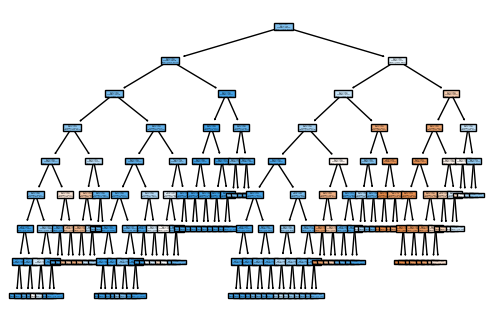

In [4]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv.get_n_splits(claims_X)

accuracy = []
precision = []
recall = []

for train_index, test_index in cv.split(claims_X):
    X_train, X_test = claims_X[train_index], claims_X[test_index]
    y_train, y_test = claims_y[train_index], claims_y[test_index]
    
    model = DecisionTreeClassifier(random_state=42)
    
    model.fit(X_train, y_train)
    
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))
    precision.append(precision_score(y_test, model.predict(X_test)))
    recall.append(recall_score(y_test, model.predict(X_test)))

accuracy = np.array(accuracy)
recall = np.array(recall)
precision = np.array(precision)

print(f'Decision Tree accuracy = {round(np.mean(accuracy), 2)}')
print(f'Decision Tree precision = {round(np.mean(precision), 2)}')
print(f'Decision Tree recall = {round(np.mean(recall), 2)}')

f = plt.figure(dpi=100)
fig = model.fit(X_train, y_train)
plot_tree(fig, filled = True)
plt.savefig('tree.png')
plt.show()

initial_model = model

# Hyperparameter Tuning
- The hyperparameters of `criterion`, `splitter`, `ccp_alpha` and `min_impurity_decrease` will be adjusted.

## How does changing `criterion` change the result?
- No change.

In [5]:
for hyperparameter in ['gini', 'entropy']:
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv.get_n_splits(claims_X)

    accuracy = []
    precision = []
    recall = []

    for train_index, test_index in cv.split(claims_X):
        X_train, X_test = claims_X[train_index], claims_X[test_index]
        y_train, y_test = claims_y[train_index], claims_y[test_index]

        model = DecisionTreeClassifier(random_state=42, criterion=hyperparameter)

        model.fit(X_train, y_train)

        accuracy.append(accuracy_score(y_test, model.predict(X_test)))
        precision.append(precision_score(y_test, model.predict(X_test)))
        recall.append(recall_score(y_test, model.predict(X_test)))

    accuracy = np.array(accuracy)
    recall = np.array(recall)
    precision = np.array(precision)

    print(f'-- {hyperparameter} --')
    print(f'Decision Tree accuracy = {round(np.mean(accuracy), 2)}')
    print(f'Decision Tree precision = {round(np.mean(precision), 2)}')
    print(f'Decision Tree recall = {round(np.mean(recall), 2)}')

-- gini --
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
-- entropy --
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93


## How does changing `splitter` change the result?
- No change.

In [6]:
for hyperparameter in ['best', 'random']:
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv.get_n_splits(claims_X)

    accuracy = []
    precision = []
    recall = []

    for train_index, test_index in cv.split(claims_X):
        X_train, X_test = claims_X[train_index], claims_X[test_index]
        y_train, y_test = claims_y[train_index], claims_y[test_index]

        model = DecisionTreeClassifier(random_state=42, splitter=hyperparameter)

        model.fit(X_train, y_train)

        accuracy.append(accuracy_score(y_test, model.predict(X_test)))
        precision.append(precision_score(y_test, model.predict(X_test)))
        recall.append(recall_score(y_test, model.predict(X_test)))

    accuracy = np.array(accuracy)
    recall = np.array(recall)
    precision = np.array(precision)

    print(f'-- {hyperparameter} --')
    print(f'Decision Tree accuracy = {round(np.mean(accuracy), 2)}')
    print(f'Decision Tree precision = {round(np.mean(precision), 2)}')
    print(f'Decision Tree recall = {round(np.mean(recall), 2)}')

-- best --
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
-- random --
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93


## How does changing the `ccp_alpha` change the result?
- Values for alpha are determined by examining the `cost_complexity_pruning_path` and using the breakpoints provided.
- The tree can be pruned from 96 leaves (every feature permutation, overfitting) to 36 leaves (much better, but still making unnecessary decisions).
- A value of `ccp_alpha` of 8.1x10^-5 produces 36 leaves with no loss in score.

-------------------------------------------------------------
ccp_alpha = 0.0
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 96



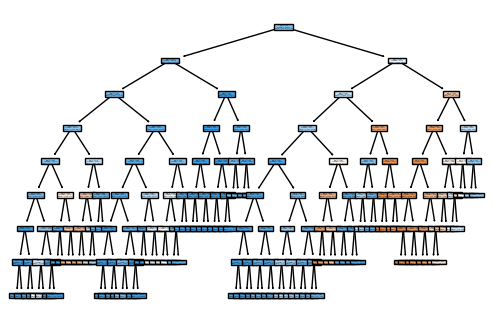

-------------------------------------------------------------
ccp_alpha = 2.798086515634103e-10
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 95

-------------------------------------------------------------
ccp_alpha = 6.350856159107604e-09
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 94

-------------------------------------------------------------
ccp_alpha = 1.522363393907742e-08
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 93

-------------------------------------------------------------
ccp_alpha = 2.7319152970102338e-08
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 92

-------------------------------------------------------------
ccp_alpha = 4.145990692709829e-08
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision T

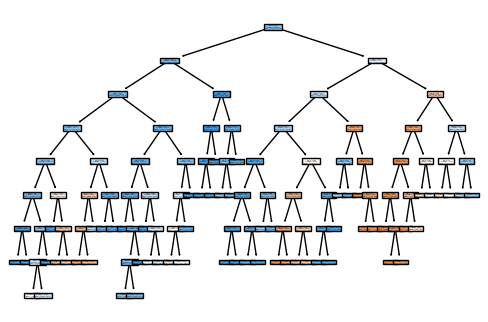

-------------------------------------------------------------
ccp_alpha = 7.117637016425347e-06
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 58

-------------------------------------------------------------
ccp_alpha = 8.099911457683327e-06
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 57



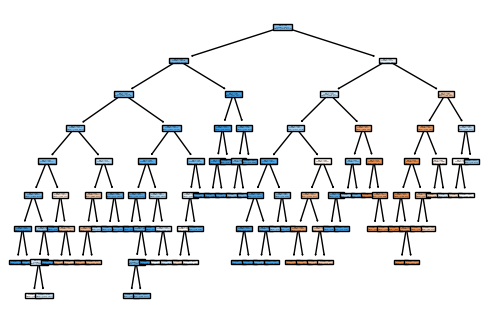

-------------------------------------------------------------
ccp_alpha = 8.470650880653633e-06
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 56

-------------------------------------------------------------
ccp_alpha = 9.420701237994756e-06
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 55



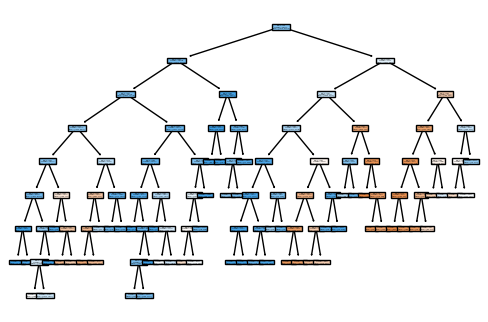

-------------------------------------------------------------
ccp_alpha = 1.3033879463636867e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 54



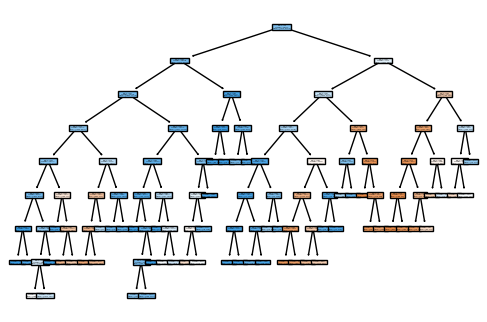

-------------------------------------------------------------
ccp_alpha = 1.487869969872763e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 53

-------------------------------------------------------------
ccp_alpha = 1.540166827606118e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 52

-------------------------------------------------------------
ccp_alpha = 1.627682572312092e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 51

-------------------------------------------------------------
ccp_alpha = 1.730267677142218e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 50

-------------------------------------------------------------
ccp_alpha = 1.835304389364396e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tr

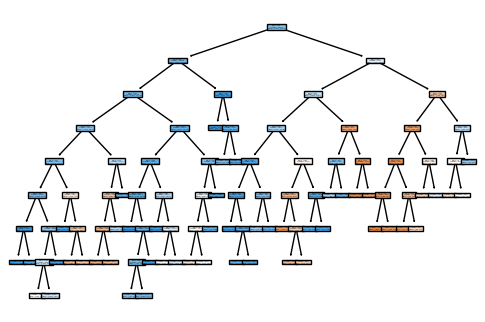

-------------------------------------------------------------
ccp_alpha = 2.278567275170503e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 48



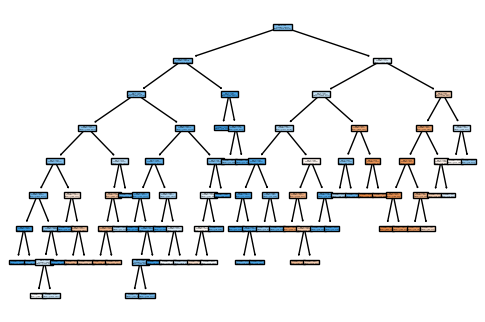

-------------------------------------------------------------
ccp_alpha = 3.263885977082114e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 47

-------------------------------------------------------------
ccp_alpha = 4.1222155850636696e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 46

-------------------------------------------------------------
ccp_alpha = 4.2265487168718224e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 45

-------------------------------------------------------------
ccp_alpha = 5.349806467690914e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 44

-------------------------------------------------------------
ccp_alpha = 5.5765948224211544e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision

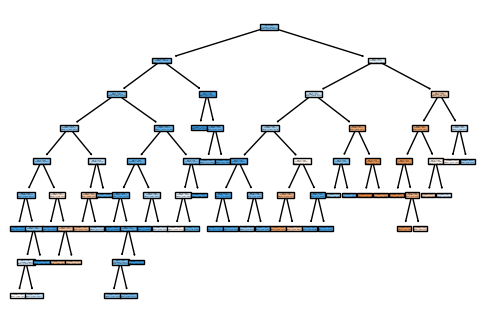

-------------------------------------------------------------
ccp_alpha = 7.242288485168817e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 40

-------------------------------------------------------------
ccp_alpha = 7.331141240987313e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 39

-------------------------------------------------------------
ccp_alpha = 7.48578080404707e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 38

-------------------------------------------------------------
ccp_alpha = 7.61938033650275e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 37

-------------------------------------------------------------
ccp_alpha = 8.064299397993798e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree

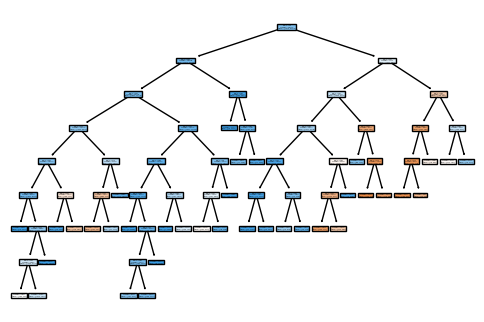

-------------------------------------------------------------
ccp_alpha = 9.165899137794468e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.92
Number of Leaves = 35



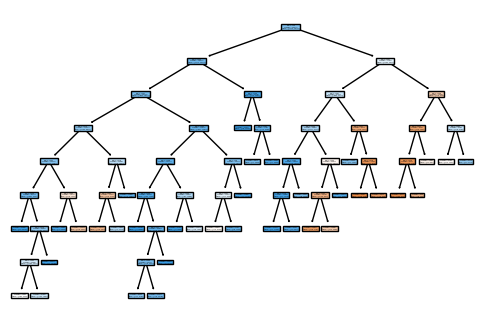

-------------------------------------------------------------
ccp_alpha = 0.00011806963728455688
Decision Tree accuracy = 0.81
Decision Tree precision = 0.85
Decision Tree recall = 0.91
Number of Leaves = 34



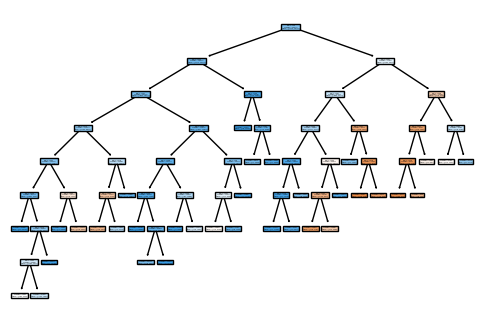

-------------------------------------------------------------
ccp_alpha = 0.00014519701985803504
Decision Tree accuracy = 0.81
Decision Tree precision = 0.85
Decision Tree recall = 0.91
Number of Leaves = 33



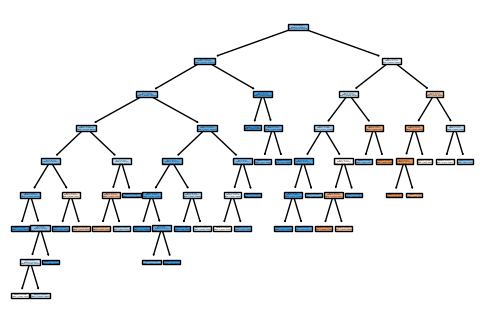

-------------------------------------------------------------
ccp_alpha = 0.00014574127995283914
Decision Tree accuracy = 0.81
Decision Tree precision = 0.85
Decision Tree recall = 0.91
Number of Leaves = 32

-------------------------------------------------------------
ccp_alpha = 0.00014785157642120727
Decision Tree accuracy = 0.81
Decision Tree precision = 0.85
Decision Tree recall = 0.91
Number of Leaves = 31

-------------------------------------------------------------
ccp_alpha = 0.00018966466533784643
Decision Tree accuracy = 0.81
Decision Tree precision = 0.85
Decision Tree recall = 0.91
Number of Leaves = 30

-------------------------------------------------------------
ccp_alpha = 0.00019935721822460055
Decision Tree accuracy = 0.81
Decision Tree precision = 0.85
Decision Tree recall = 0.91
Number of Leaves = 29

-------------------------------------------------------------
ccp_alpha = 0.0003434111909957089
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decisio

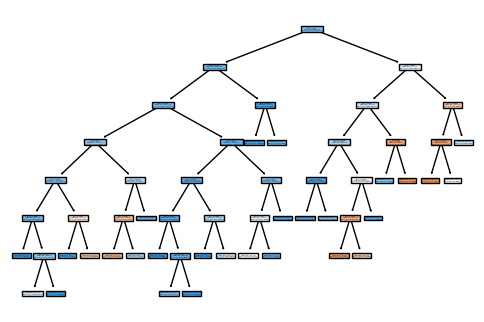

-------------------------------------------------------------
ccp_alpha = 0.0004196897459568579
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.92
Number of Leaves = 27



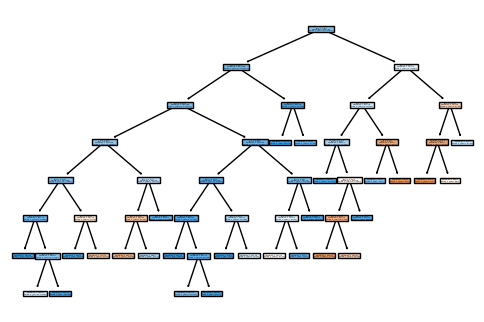

-------------------------------------------------------------
ccp_alpha = 0.0007498287979596681
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.92
Number of Leaves = 26

-------------------------------------------------------------
ccp_alpha = 0.0009520250065218859
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.92
Number of Leaves = 25



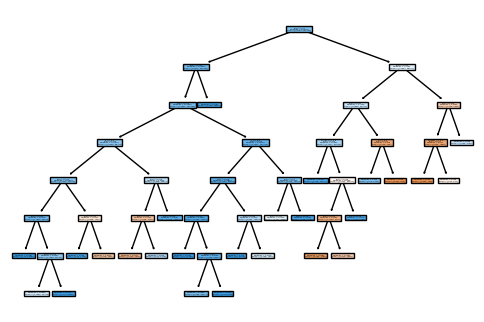

-------------------------------------------------------------
ccp_alpha = 0.0009683286518771305
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.92
Number of Leaves = 24



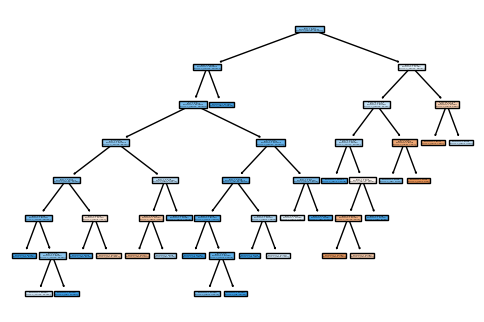

-------------------------------------------------------------
ccp_alpha = 0.0010073360401007675
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 23



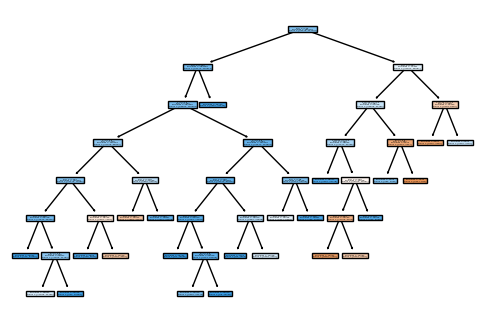

-------------------------------------------------------------
ccp_alpha = 0.0010140702159346891
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 22

-------------------------------------------------------------
ccp_alpha = 0.0022088890776120126
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 21



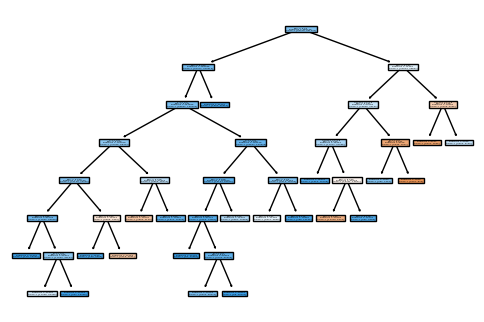

-------------------------------------------------------------
ccp_alpha = 0.002483163520416008
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 20



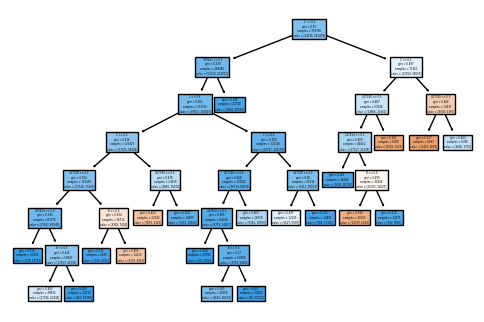

-------------------------------------------------------------
ccp_alpha = 0.0029324047533548885
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.92
Number of Leaves = 19



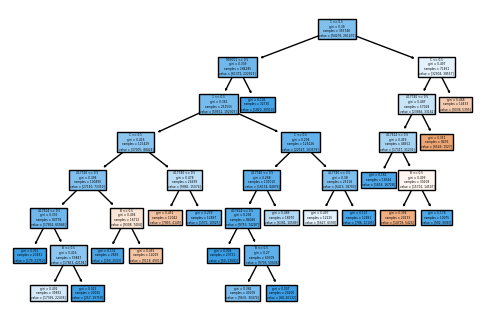

-------------------------------------------------------------
ccp_alpha = 0.003325417068528333
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.92
Number of Leaves = 17



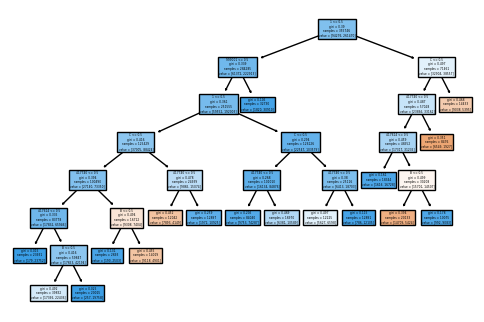

-------------------------------------------------------------
ccp_alpha = 0.004007618005148483
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.92
Number of Leaves = 14

-------------------------------------------------------------
ccp_alpha = 0.004270176862575938
Decision Tree accuracy = 0.8
Decision Tree precision = 0.84
Decision Tree recall = 0.91
Number of Leaves = 13



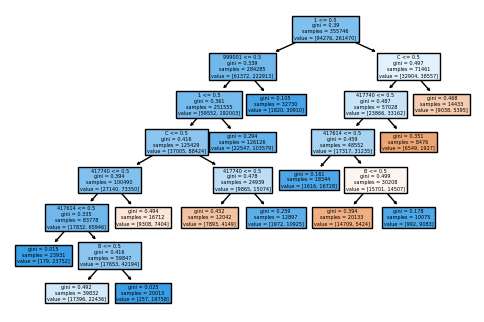

-------------------------------------------------------------
ccp_alpha = 0.007343976117790529
Decision Tree accuracy = 0.78
Decision Tree precision = 0.8
Decision Tree recall = 0.95
Number of Leaves = 6



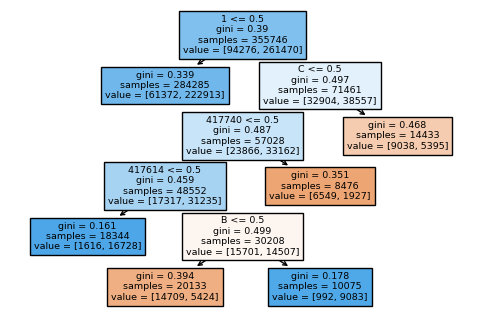

-------------------------------------------------------------
ccp_alpha = 0.009213720260659787
Decision Tree accuracy = 0.74
Decision Tree precision = 0.75
Decision Tree recall = 0.99
Number of Leaves = 2



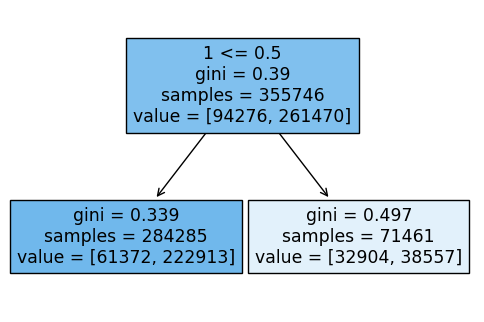

-------------------------------------------------------------
ccp_alpha = 0.01920266986438668
Decision Tree accuracy = 0.73
Decision Tree precision = 0.73
Decision Tree recall = 1.0
Number of Leaves = 1



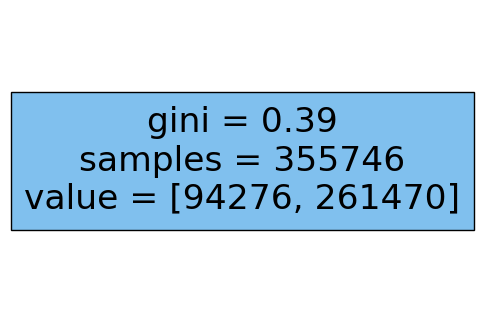

,ccp_alpha,accuracy,precision,recall,n_leaves
0,0.000000e+00,0.814220,0.833033,0.934510,96
1,2.798087e-10,0.814220,0.833033,0.934510,95
2,6.350856e-09,0.814220,0.833033,0.934510,94
3,1.522363e-08,0.814220,0.833033,0.934510,93
4,2.731915e-08,0.814220,0.833033,0.934510,92
...,...,...,...,...,...
78,4.007618e-03,0.806414,0.835917,0.916472,14
79,4.270177e-03,0.799846,0.835059,0.906738,13
80,7.343976e-03,0.784390,0.795463,0.951186,6
81,9.213720e-03,0.744631,0.746877,0.990292,2


In [7]:
results = []

previous_accuracy = 1
previous_precision = 1
previous_recall = 1

for hyperparameter in initial_model.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas']:
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv.get_n_splits(claims_X)

    accuracy = []
    precision = []
    recall = []

    for train_index, test_index in cv.split(claims_X):
        X_train, X_test = claims_X[train_index], claims_X[test_index]
        y_train, y_test = claims_y[train_index], claims_y[test_index]

        model = DecisionTreeClassifier(random_state=42, ccp_alpha=hyperparameter)

        model.fit(X_train, y_train)

        accuracy.append(accuracy_score(y_test, model.predict(X_test)))
        precision.append(precision_score(y_test, model.predict(X_test)))
        recall.append(recall_score(y_test, model.predict(X_test)))

    accuracy = np.array(accuracy)
    precision = np.array(precision)
    recall = np.array(recall)

    result = {'ccp_alpha':hyperparameter,
              'accuracy': np.mean(accuracy),
              'precision': np.mean(precision),
              'recall': np.mean(recall),
              'n_leaves': model.get_n_leaves()}
    results.append(result)
    
    print('-------------------------------------------------------------')
    print(f'ccp_alpha = {hyperparameter}')
    print(f'Decision Tree accuracy = {round(np.mean(accuracy), 2)}')
    print(f'Decision Tree precision = {round(np.mean(precision), 2)}')
    print(f'Decision Tree recall = {round(np.mean(recall), 2)}')
    print(f'Number of Leaves = {model.get_n_leaves()}' + '\n')
    
    if np.isclose(result['accuracy'], previous_accuracy) and np.isclose(result['precision'], previous_precision) and np.isclose(result['recall'], previous_recall):
        pass
    else:
        names = [x.split('_')[1] for x in ohe.get_feature_names()]
        f = plt.figure(dpi=100)
        fig = model.fit(X_train, y_train)
        plot_tree(fig, filled = True, feature_names=names)
        plt.show()
    previous_accuracy = result['accuracy']
    previous_precision = result['precision']
    previous_recall = result['recall']
    
results = pd.DataFrame(results)
display(results)

## How does changing `min_impurity_decrease` change the result?
- Small (10^-5) perturbations of the parameter results in significant changes in the tree structure.

-------------------------------------------------------------
min_impurity_decrease = 0.0
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 96



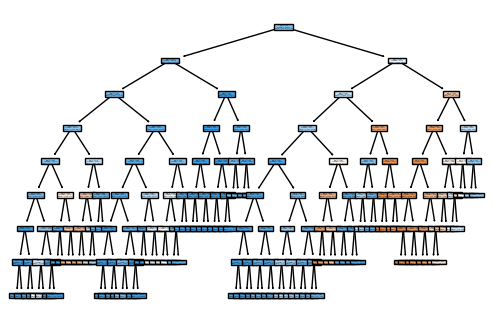

-------------------------------------------------------------
min_impurity_decrease = 2e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.83
Decision Tree recall = 0.93
Number of Leaves = 49



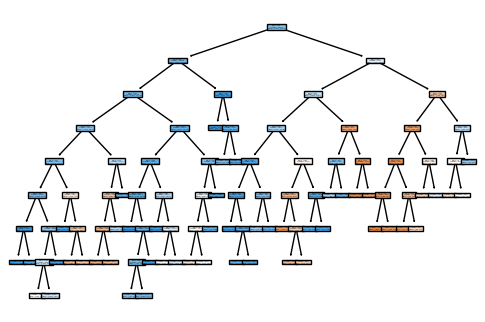

-------------------------------------------------------------
min_impurity_decrease = 4e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 47



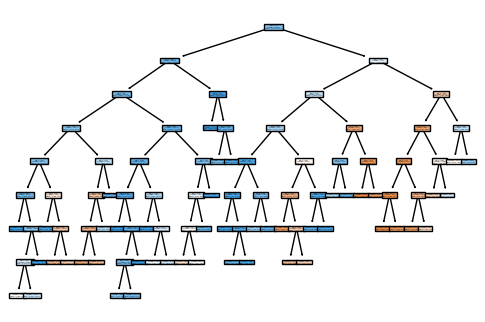

-------------------------------------------------------------
min_impurity_decrease = 6.000000000000001e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 42



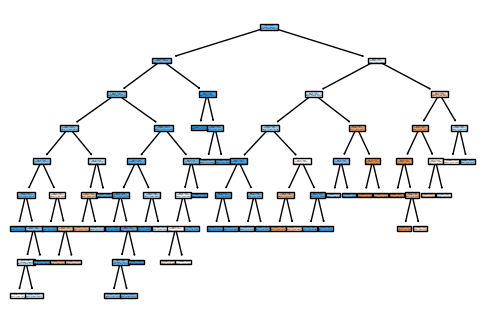

-------------------------------------------------------------
min_impurity_decrease = 8e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 37



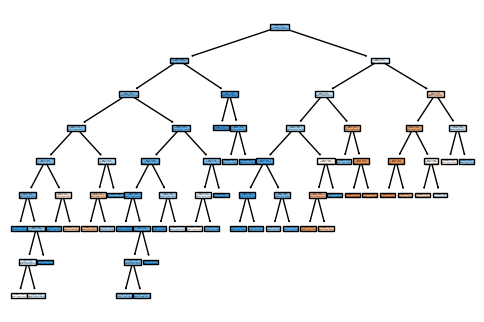

-------------------------------------------------------------
min_impurity_decrease = 0.0001
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.91
Number of Leaves = 35



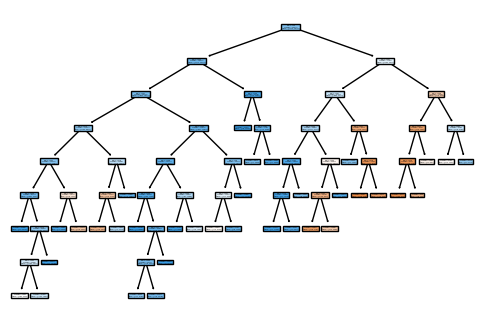

-------------------------------------------------------------
min_impurity_decrease = 0.00012000000000000002
Decision Tree accuracy = 0.81
Decision Tree precision = 0.85
Decision Tree recall = 0.91
Number of Leaves = 34



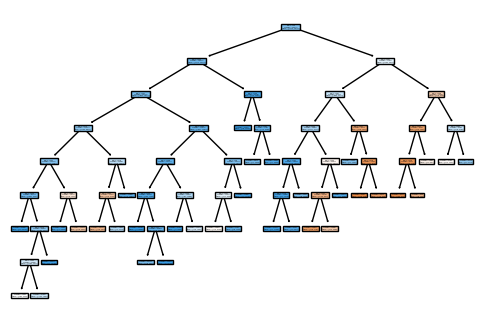

-------------------------------------------------------------
min_impurity_decrease = 0.00014000000000000001
Decision Tree accuracy = 0.81
Decision Tree precision = 0.85
Decision Tree recall = 0.91
Number of Leaves = 34



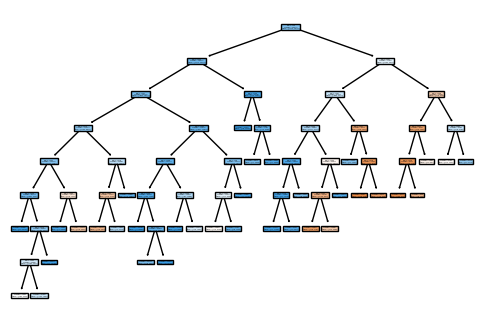

-------------------------------------------------------------
min_impurity_decrease = 0.00016
Decision Tree accuracy = 0.81
Decision Tree precision = 0.85
Decision Tree recall = 0.91
Number of Leaves = 31



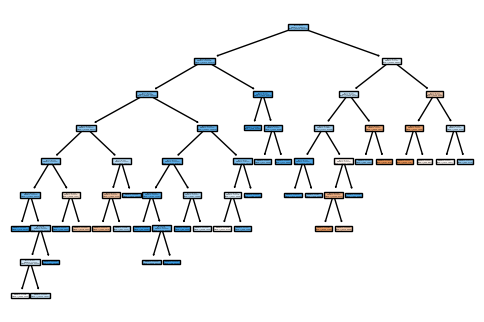

-------------------------------------------------------------
min_impurity_decrease = 0.00018
Decision Tree accuracy = 0.81
Decision Tree precision = 0.85
Decision Tree recall = 0.91
Number of Leaves = 31



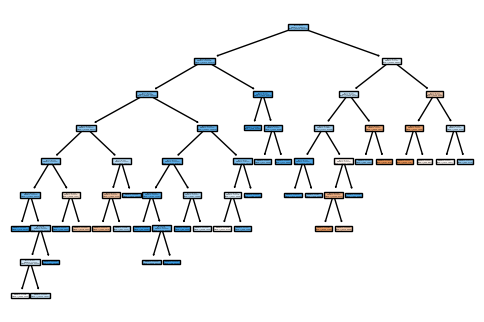

-------------------------------------------------------------
min_impurity_decrease = 0.0002
Decision Tree accuracy = 0.81
Decision Tree precision = 0.85
Decision Tree recall = 0.91
Number of Leaves = 29



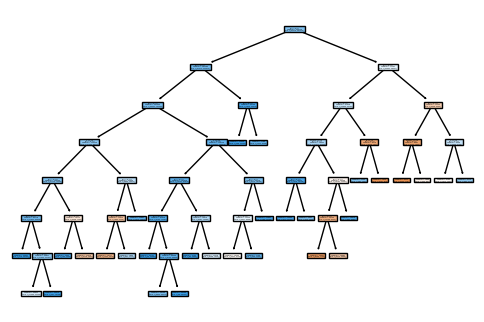

,min_impurity_decrease,accuracy,precision,recall,n_leaves
0,0.00000,0.814220,0.833033,0.934510,96
1,0.00002,0.814202,0.834609,0.931849,49
2,0.00004,0.814247,0.835205,0.930921,47
3,0.00006,0.814247,0.835205,0.930921,42
4,0.00008,0.814375,0.836625,0.928855,37
5,0.00010,0.813773,0.844864,0.914516,35
6,0.00012,0.813725,0.845054,0.914141,34
7,0.00014,0.813694,0.845289,0.913718,34
8,0.00016,0.813694,0.845289,0.913718,31
9,0.00018,0.813694,0.845289,0.913718,31


In [8]:
results = []
model = initial_model
for min_impurity_decrease in np.linspace(0, 0.0002, 11):
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv.get_n_splits(claims_X)

    accuracy = []
    precision = []
    recall = []

    for train_index, test_index in cv.split(claims_X):
        X_train, X_test = claims_X[train_index], claims_X[test_index]
        y_train, y_test = claims_y[train_index], claims_y[test_index]

        model = DecisionTreeClassifier(random_state=42, min_impurity_decrease=min_impurity_decrease)

        model.fit(X_train, y_train)

        accuracy.append(accuracy_score(y_test, model.predict(X_test)))
        precision.append(precision_score(y_test, model.predict(X_test)))
        recall.append(recall_score(y_test, model.predict(X_test)))

    accuracy = np.array(accuracy)
    precision = np.array(precision)
    recall = np.array(recall)

    result = {'min_impurity_decrease': min_impurity_decrease,
              'accuracy': np.mean(accuracy),
              'precision': np.mean(precision),
              'recall': np.mean(recall),
              'n_leaves': model.get_n_leaves()}
    results.append(result)

    print('-------------------------------------------------------------')
    print(f'min_impurity_decrease = {min_impurity_decrease}')
    print(f'Decision Tree accuracy = {round(np.mean(accuracy), 2)}')
    print(f'Decision Tree precision = {round(np.mean(precision), 2)}')
    print(f'Decision Tree recall = {round(np.mean(recall), 2)}')
    print(f'Number of Leaves = {model.get_n_leaves()}' + '\n')
    
    names = [x.split('_')[1] for x in ohe.get_feature_names()]
    f = plt.figure(dpi=100)
    fig = model.fit(X_train, y_train)
    plot_tree(fig, filled = True, feature_names=names)
    plt.show()
    previous_accuracy = result['accuracy']
    previous_precision = result['precision']
    previous_recall = result['recall']

results = pd.DataFrame(results)
display(results)

## How does changing `min_impurity_decrease` while holding `ccp_alpha` to 8.1x10^-5?
- No main decrease in number of leaves while retaining scores.

-------------------------------------------------------------
min_impurity_decrease =  0.0
ccp_alpha = 8.1e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 36



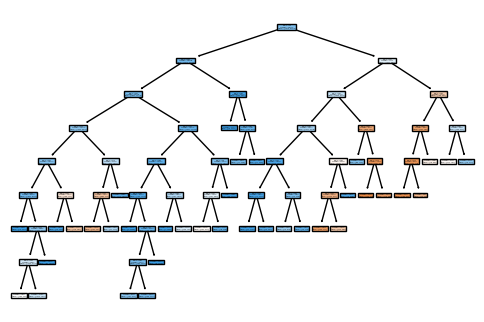

-------------------------------------------------------------
min_impurity_decrease =  2e-05
ccp_alpha = 8.1e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 36



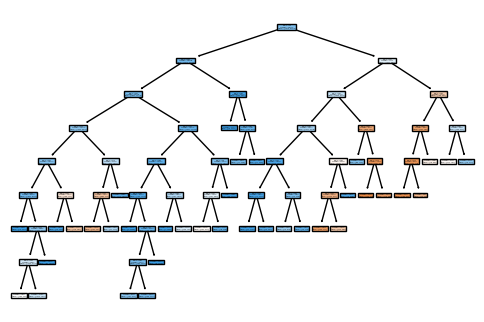

-------------------------------------------------------------
min_impurity_decrease =  4e-05
ccp_alpha = 8.1e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 36



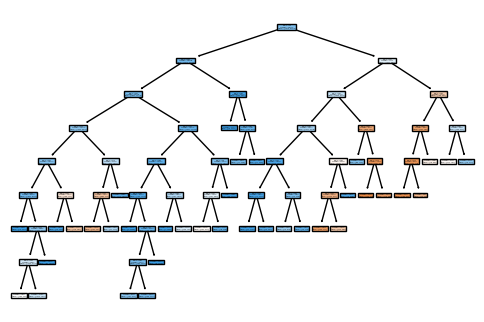

-------------------------------------------------------------
min_impurity_decrease =  6.000000000000001e-05
ccp_alpha = 8.1e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 36



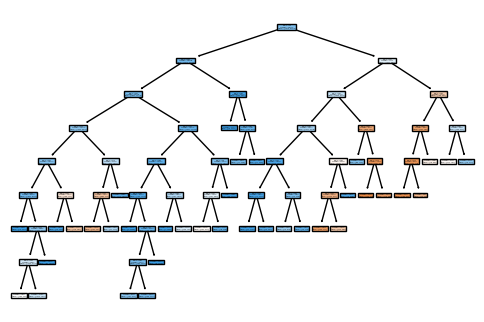

-------------------------------------------------------------
min_impurity_decrease =  8e-05
ccp_alpha = 8.1e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 36



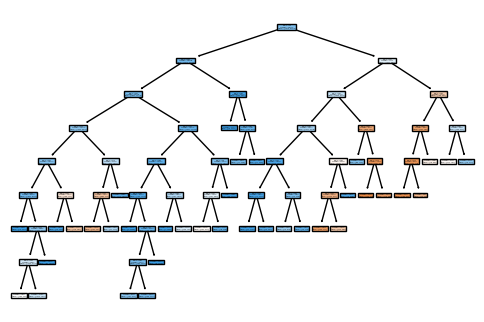

-------------------------------------------------------------
min_impurity_decrease =  0.0001
ccp_alpha = 8.1e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.91
Number of Leaves = 35



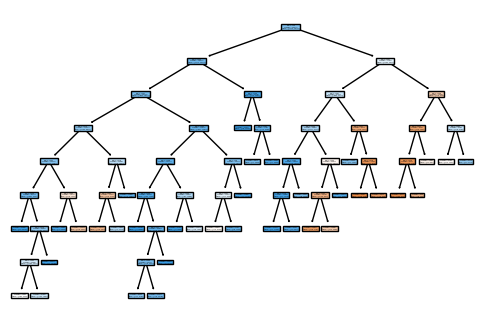

-------------------------------------------------------------
min_impurity_decrease =  0.00012000000000000002
ccp_alpha = 8.1e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.85
Decision Tree recall = 0.91
Number of Leaves = 34



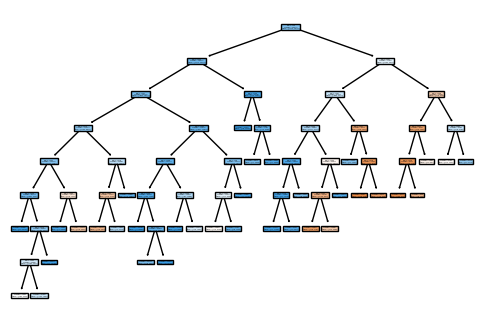

-------------------------------------------------------------
min_impurity_decrease =  0.00014000000000000001
ccp_alpha = 8.1e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.85
Decision Tree recall = 0.91
Number of Leaves = 34



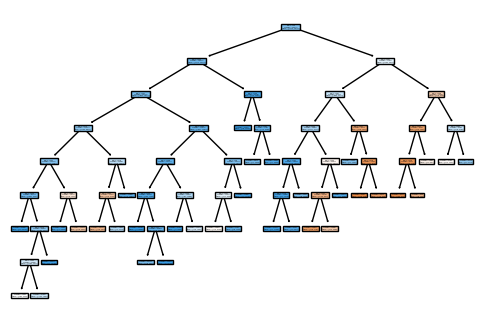

-------------------------------------------------------------
min_impurity_decrease =  0.00016
ccp_alpha = 8.1e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.85
Decision Tree recall = 0.91
Number of Leaves = 31



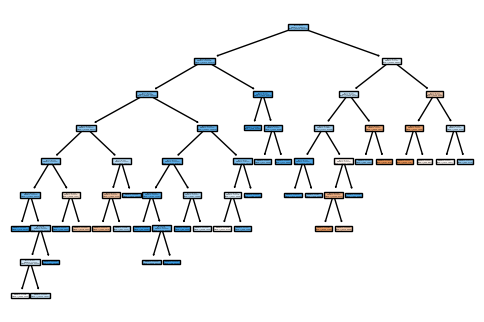

-------------------------------------------------------------
min_impurity_decrease =  0.00018
ccp_alpha = 8.1e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.85
Decision Tree recall = 0.91
Number of Leaves = 31



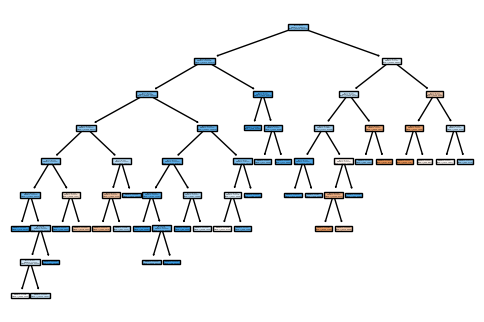

-------------------------------------------------------------
min_impurity_decrease =  0.0002
ccp_alpha = 8.1e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.85
Decision Tree recall = 0.91
Number of Leaves = 29



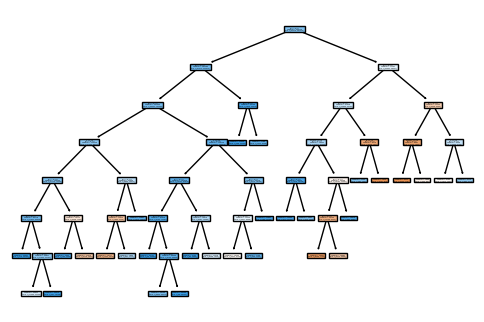

,min_impurity_decrease,ccp_alpha,accuracy,precision,recall,n_leaves
0,0.00000,0.000081,0.814265,0.836794,0.928405,36
1,0.00002,0.000081,0.814265,0.836794,0.928405,36
2,0.00004,0.000081,0.814265,0.836794,0.928405,36
3,0.00006,0.000081,0.814265,0.836794,0.928405,36
4,0.00008,0.000081,0.814265,0.836794,0.928405,36
5,0.00010,0.000081,0.813773,0.844864,0.914516,35
6,0.00012,0.000081,0.813725,0.845054,0.914141,34
7,0.00014,0.000081,0.813694,0.845289,0.913718,34
8,0.00016,0.000081,0.813694,0.845289,0.913718,31
9,0.00018,0.000081,0.813694,0.845289,0.913718,31


In [9]:
results = []
ccp_alpha = 8.1*10**-5
model = initial_model
for min_impurity_decrease in np.linspace(0, 0.0002, 11):
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv.get_n_splits(claims_X)

    accuracy = []
    precision = []
    recall = []

    for train_index, test_index in cv.split(claims_X):
        X_train, X_test = claims_X[train_index], claims_X[test_index]
        y_train, y_test = claims_y[train_index], claims_y[test_index]

        model = DecisionTreeClassifier(random_state=42, min_impurity_decrease=min_impurity_decrease, ccp_alpha=ccp_alpha)

        model.fit(X_train, y_train)

        accuracy.append(accuracy_score(y_test, model.predict(X_test)))
        precision.append(precision_score(y_test, model.predict(X_test)))
        recall.append(recall_score(y_test, model.predict(X_test)))

    accuracy = np.array(accuracy)
    precision = np.array(precision)
    recall = np.array(recall)

    result = {'min_impurity_decrease': min_impurity_decrease,
              'ccp_alpha': ccp_alpha,
              'accuracy': np.mean(accuracy),
              'precision': np.mean(precision),
              'recall': np.mean(recall),
              'n_leaves': model.get_n_leaves()}
    results.append(result)

    print('-------------------------------------------------------------')
    print(f'min_impurity_decrease =  {min_impurity_decrease}')
    print(f'ccp_alpha = {ccp_alpha}')
    print(f'Decision Tree accuracy = {round(np.mean(accuracy), 2)}')
    print(f'Decision Tree precision = {round(np.mean(precision), 2)}')
    print(f'Decision Tree recall = {round(np.mean(recall), 2)}')
    print(f'Number of Leaves = {model.get_n_leaves()}' + '\n')
    
    names = [x.split('_')[1] for x in ohe.get_feature_names()]
    f = plt.figure(dpi=100)
    fig = model.fit(X_train, y_train)
    plot_tree(fig, filled = True, feature_names=names)
    plt.show()
    previous_accuracy = result['accuracy']
    previous_precision = result['precision']
    previous_recall = result['recall']

results = pd.DataFrame(results)
display(results)

# Current Best Model
- A `ccp_alpha` of 8.1x10^-5 is used to trim the tree complexity.

ccp_alpha =  8.1e-05
Decision Tree accuracy = 0.81
Decision Tree precision = 0.84
Decision Tree recall = 0.93
Number of Leaves = 36



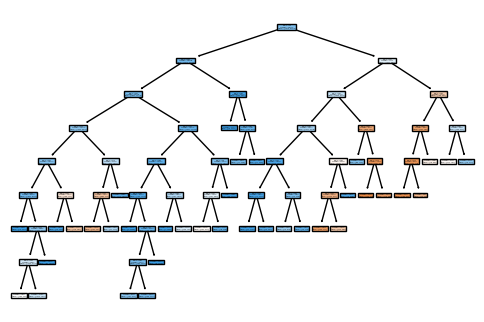

In [10]:
ccp_alpha = 8.1 * 10 ** -5

cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv.get_n_splits(claims_X)

accuracy = []
precision = []
recall = []

for train_index, test_index in cv.split(claims_X):
    X_train, X_test = claims_X[train_index], claims_X[test_index]
    y_train, y_test = claims_y[train_index], claims_y[test_index]

    model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)

    model.fit(X_train, y_train)
    
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))
    precision.append(precision_score(y_test, model.predict(X_test)))
    recall.append(recall_score(y_test, model.predict(X_test)))

accuracy = np.array(accuracy)
recall = np.array(recall)
precision = np.array(precision)

print(f'ccp_alpha =  {ccp_alpha}')
print(f'Decision Tree accuracy = {round(np.mean(accuracy), 2)}')
print(f'Decision Tree precision = {round(np.mean(precision), 2)}')
print(f'Decision Tree recall = {round(np.mean(recall), 2)}')
print(f'Number of Leaves = {model.get_n_leaves()}' + '\n')

names = [x.split('_')[1] for x in ohe.get_feature_names()]
f = plt.figure(dpi=100)
fig = model.fit(X_train, y_train)
plot_tree(fig, filled = True, feature_names=names)
plt.show()